# Modelling

The goal is to create model that will predict forex-pair value movements

### Plan: 

From the data:
1. Generate sentiment analysis using FinBERT model on a daily basis
2. `groupby()` the days and get the average sentiment 
3. Append the average daily sentiment and import over to another data `final_dataset`
4. `final_dataset` will have columns => `close_price`, `open_price`, `change_in_price`, `date`, `avg_news_sentiment` 
5. Use `Prophet` by Facebook first because its a sci-kit learn based model

Testing: 
1. Remove last week and try to predict this week's prices 

# Formatting for Modelling

1. Include sentiment analysis after retrieving data 
2. Change data to datetime 

EURUSD=X modelling

In [26]:
import pandas as pd
import numpy as np 
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import scipy

from prophet import Prophet

import yfinance as yf 

import tensorflow

### Database Cleaning & Formatting

In [27]:
articles = pd.read_parquet(r"../data/raw_scrapped_data/EURUSD=X_fxstreet_database")
# print(articles.columns) # DEBUG
# print(articles.describe) # DEBUG


In [28]:
# Init FinBERT
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

## Attach Ticker Values by the Publishing Date

*Optimize*

The thing about this function is that it averages throughout the whole hour. We could have done something similar to; 

If less than 30 mins the hour, get to the starting hour 
If more than 30 mins to the hour

Found to have lots of errors so I had to modify `find_ticker_val()` function to have a try and error catching. One of the errors were that on Weekends, stock market prices were not tracked thus no records. If `following_day` were to land on a Saturday, it would through an error.

Another is that days not within the market or have not been saved yet. Cases within days `2025-03-22` and onwards. We'll have to find a way: 

1. Safe keep the data (massive storage for all the articles) 
2. Find ticker values if possible
3. Remove NaNs 
4. Append to final modelling dataset. 

Then: 

1. For each article that is not in the final modelling dataset, try to find the `ticker_val` again. (Will incur compute costs though so we'll iterate through the lists) 
2. Append into final modelling dataset.

## Attach Ticker Values by the Daily Average 

1. Produce sentiment polarity value per article
2. Aggregate sentiment polarity by date 
3. Append daily high and low values (predict via range)
4. Calculate the daily difference! 

Test case: EURUSD

In [ ]:
# Load in raw article data 

# Load in finBERT AutoTokenizer & Classifier

Attach the sentiment! 

In [30]:
def analyze_sentiment(x):

    # Determine how BERT will analyze the text
    tokenizer_kwargs = {
    "padding" : True,
    "truncation" : True,
    "max_length" : 512,
    }

    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = finbert(**input_sequence).logits
        # Apply softmax to get probabilities 
        prob = scipy.special.softmax(logits.numpy().squeeze())
        weights = {
            0 : -1, # Negative
            1 : 0, # Neutral
            2 : 1 # Positive
        }
        # Calculate polarity score
        polarity = sum(prob[i] * weights[i] for i in range(len(prob)))
    return polarity # Returns raw sentiment scores (as probabilities)

articles['sentiment_polarity'] = articles['text'].apply(analyze_sentiment)

# Ref: 
# https://www.kaggle.com/code/mexwell/huggingface-finbert-for-sentiment-analysis 2025-03-22
# https://medium.com/@ravirajshinde2000/financial-news-sentiment-analysis-using-finbert-25afcc95e65f 2025-03-22


Convert all the `date` rows into datetime objs

In [31]:
def convert_to_datetime(date_str):
    date_format = "%m/%d/%Y %H:%M:%S GMT"
    return datetime.strptime(date_str, date_format)

articles['date'] = articles['date'].apply(convert_to_datetime) # Override! 

Now, aggregate the sentiment polarity by date and average them! 

Then Add in daily high and low data. 

We should actually include other data that is available from yfinance and use them as additional regressors/ predictors to the model, perhaps it can give better accuracy? 

For improvements to the model AFTER the presentation, we'll be adding in 'Open' and 'Close' data!

In [42]:
EURUSD = yf.Ticker("EURUSD=X")

articles1 = articles.copy()

print("--------------------------------------------")
print(f"The total na values: \n {articles1.isna().sum()}")
print("--------------------------------------------")

# Getting average daily news sentiment 

def get_params_val(start, end, ticker):
    ticker_data = ticker.history(start=start, end=end, interval="1d").reset_index()
    return float(ticker_data.loc[0,'High']), float(ticker_data.loc[0,'Low']), float(ticker_data.loc[0,'Open']), float(ticker_data.loc[0,'Close'])

# Function for finding daily ticker values; high and low 
# def find_params_val(day, ticker):
#     following_day = day + timedelta(days=1)
#     try:
#         return get_params_val(day, following_day, ticker)
#     except:
#         try: # For when posted on a Saturday, go one day back 
#             previous_day = day - timedelta(days=1)
#             return get_params_val(previous_day, day, ticker)
#         except: 
#             try: # For when posted on a sunday, go one day back 
#                 previous_2_days = day - timedelta(days=2)
#                 return get_params_val(previous_2_days, previous_day, ticker)
#             except:
#                 print(f"Error: for {day} and {following_day}")
#                 return None, None

# This version of find_params_val only appends `sentiment_polarity` to intra-day articles. Weekends are excluded
def find_params_val(day, ticker):
    following_day = day + timedelta(days=1)
    try:
        return get_params_val(day, following_day, ticker)
    except:
        print(f"Error: for {day} and {following_day}")
        return None, None

def format_articles_to_daily(articles, ticker): 
    # Get the aggregated daily sentiment
    daily_sentiment = articles[['date','sentiment_polarity']].groupby([articles['date'].dt.date]).mean('sentiment_polarity').reset_index()

    # Add in daily high and low data 
    daily_sentiment[['High','Low','Open','Close']] = pd.DataFrame(daily_sentiment['date'].apply(lambda day: find_params_val(day, ticker)).tolist(), index=daily_sentiment.index)

    print("--------------------------------------------")
    print(f"The number of null 'High' and 'Low' values found  \n {daily_sentiment.isnull().sum()}")
    print("--------------------------------------------")
    daily_sentiment.dropna(inplace=True)

    daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

    return daily_sentiment

articles1 = format_articles_to_daily(articles1, EURUSD)
print(articles1.info())

--------------------------------------------
The total na values: 
 title                 0
link                  0
date                  0
text                  0
sentiment_polarity    0
dtype: int64
--------------------------------------------
Error: for 2025-02-23 and 2025-02-24
--------------------------------------------
The number of null 'High' and 'Low' values found  
 date                  0
sentiment_polarity    0
High                  1
Low                   1
Open                  1
Close                 1
dtype: int64
--------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 0 to 119
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                119 non-null    datetime64[ns]
 1   sentiment_polarity  119 non-null    float64       
 2   High                119 non-null    float64       
 3   Low                 119 non-null  

Limitations: 

We find that some articles are 'forecasting' like: Trump will place tarrifs, heres how the USD is impacted in the next couple days. But you can also have current market indicators: 'USD is like this because of Trump's tarrifs'. 

In [43]:
articles1

,date,sentiment_polarity,High,Low,Open,Close
0,2024-10-09,0.775951,1.098056,1.094068,1.097574,1.097574
1,2024-10-10,0.681009,1.095446,1.091405,1.094331,1.094331
2,2024-10-11,0.514638,1.095422,1.092741,1.093386,1.093386
3,2024-10-14,0.693515,1.093972,1.090572,1.092538,1.092538
4,2024-10-15,0.746610,1.091822,1.088578,1.090917,1.090917
...,...,...,...,...,...,...
115,2025-03-25,0.616771,1.083072,1.077865,1.080357,1.080357
116,2025-03-26,0.769901,1.080229,1.076878,1.078749,1.078749
117,2025-03-27,0.527181,1.081876,1.074206,1.074206,1.074206
118,2025-03-28,0.546318,1.084528,1.076589,1.080100,1.080100


Analysis: Pearson Correlation of Lag

In [44]:
def get_lag_corr_of_vals(dataframe, param):
    values = pd.DataFrame(articles1[param].values)
    dataframe = pd.concat([values.shift(1), values], axis = 1)
    dataframe.columns = ['t-1', 't+1']
    result = dataframe.corr()
    print("-------------------------------------------------------------------------")
    print(f"The Pearson correlation coefficient for the lag of Daily '{param}' Difference Forex value is: \n{result}")

for param in ['High','Low','Open','Close','sentiment_polarity']:
    get_lag_corr_of_vals(articles1, param)


-------------------------------------------------------------------------
The Pearson correlation coefficient for the lag of Daily 'High' Difference Forex value is: 
          t-1       t+1
t-1  1.000000  0.974164
t+1  0.974164  1.000000
-------------------------------------------------------------------------
The Pearson correlation coefficient for the lag of Daily 'Low' Difference Forex value is: 
         t-1      t+1
t-1  1.00000  0.97104
t+1  0.97104  1.00000
-------------------------------------------------------------------------
The Pearson correlation coefficient for the lag of Daily 'Open' Difference Forex value is: 
          t-1       t+1
t-1  1.000000  0.967634
t+1  0.967634  1.000000
-------------------------------------------------------------------------
The Pearson correlation coefficient for the lag of Daily 'Close' Difference Forex value is: 
          t-1       t+1
t-1  1.000000  0.967638
t+1  0.967638  1.000000
------------------------------------------------------

So it seems like, the best way we can model it is through ticker values alone, but although using Ticker values themselves (for EURUSD) gives us 0.996379 Pearson Correlation Coeffficient, it's always statistically best to give predicted values within a range. Because we haven't been taught how to generate 95% confidence intervals for complex modelling techniques (apart from regression techniques taught in DATA 603) we'll opt to provide a forecast of `High` and `Low` -est values in the following day. 

This is also because we've aggregated our sentiment as per day - `yfinance` API does not provide an 'average daily value' for tickers, we are only given the highest and lowest value of a ticker in a given day. We are limited by the data we are provided with from our API

We should also look at the correlation of values between our predictors; Open, Close (for days thats have passed already, not available for current-day predictions) & sentiment_polarity, to our target; High and Low. 

In [45]:
def get_corr_of_pred_and_tar(dataframe, target):
    # dataframe = dataframe.drop(columns=exclusion)
    result = dataframe.corr()[target]
    print("---------------------------------------------------------------------------")
    print(f"The Pearson correlation coefficient for {target} against all : \n{result}")

for target in ['High','Low']:
    get_corr_of_pred_and_tar(articles1, target)

# Ref: 
# https://saturncloud.io/blog/how-to-calculate-pandas-correlation-of-one-column-against-all-others/

---------------------------------------------------------------------------
The Pearson correlation coefficient for High against all : 
date                 -0.181421
sentiment_polarity   -0.084655
High                  1.000000
Low                   0.988472
Open                  0.989281
Close                 0.989285
Name: High, dtype: float64
---------------------------------------------------------------------------
The Pearson correlation coefficient for Low against all : 
date                 -0.194983
sentiment_polarity   -0.067640
High                  0.988472
Low                   1.000000
Open                  0.988060
Close                 0.988066
Name: Low, dtype: float64


This gives us the answers to; which parameters should we consider? We should focus on using the data retrieved from yFinance instead of using sentiment_polarity! 

As for our test case right now: 

1. lag of `sentiment_polarity` = 0.042087
2. Pearson Corr of `sentiment_polarity` and `High` = -0.092077
3. Pearson Corr of `sentiment_polarity` and `Low` = -0.074192

For a total of: `|0.208356|`

We are just looking to see if we can actually make use of our web-scrapped articles data! 

-----

The current method makes it so that weekend-posted articles' sentiment polarities are aggregated to Friday (last most recent market-day). This is because Yahoo Finance only tracks the market value of days the market is open.

For when we remove weekend articles:
1. lag of `sentiment_polarity` = 0.07055
2. Pearson Corr of `sentiment_polarity` and `High` = -0.084655
3. Pearson Corr of `sentiment_polarity` and `Low` = -0.067640

For a total of: `|0.222845|`


-----

What if instead, we push the values forward as the articles foreshadow the events of the coming monday? 

for when we push weekend articles to the following Monday:
1. lag of `sentiment_polarity` = 0.042087
2. Pearson Corr of `sentiment_polarity` and `High` = -0.090461
3. Pearson Corr of `sentiment_polarity` and `Low` = -0.073865

For a total of: `|0.206413|`

*Conclusion* 

Through these test cases, although it's only within one time range, it's obvious we have the greatest correlation when we EXCLUDE the weekend articles! Fascinating? I don't know

We should also add other features now too! 

Simple Moving Average:

In [110]:
def calc_sma(df, target, window):
    return df[target].rolling(window=window).mean()

def get_sma_for_preds(dataframe, window, dropped_cols):
    for target in list(dataframe.drop(columns=dropped_cols).columns):
        col_name_sma = f'{target}_sma'
        dataframe[col_name_sma] = calc_sma(dataframe, target, window)
    return dataframe

articles2 = articles1.copy()
articles2 = get_sma_for_preds(articles2, 20, 'date')

# Ref: 
# https://gregorycernera.medium.com/computing-simple-moving-average-sma-with-python-pandas-yfinance-0458bb0b5d3b

In [111]:
display(articles2)

,date,sentiment_polarity,High,Low,Open,Close,sentiment_polarity_sma,High_sma,Low_sma,Open_sma,Close_sma
0,2024-10-09,0.775951,1.098056,1.094068,1.097574,1.097574,NaN,NaN,NaN,NaN,NaN
1,2024-10-10,0.681009,1.095446,1.091405,1.094331,1.094331,NaN,NaN,NaN,NaN,NaN
2,2024-10-11,0.514638,1.095422,1.092741,1.093386,1.093386,NaN,NaN,NaN,NaN,NaN
3,2024-10-14,0.693515,1.093972,1.090572,1.092538,1.092538,NaN,NaN,NaN,NaN,NaN
4,2024-10-15,0.746610,1.091822,1.088578,1.090917,1.090917,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
115,2025-03-25,0.616771,1.083072,1.077865,1.080357,1.080357,0.691195,1.079319,1.071515,1.075103,1.075103
116,2025-03-26,0.769901,1.080229,1.076878,1.078749,1.078749,0.691149,1.080694,1.072977,1.076420,1.076420
117,2025-03-27,0.527181,1.081876,1.074206,1.074206,1.074206,0.685119,1.082338,1.074663,1.077687,1.077687
118,2025-03-28,0.546318,1.084528,1.076589,1.080100,1.080100,0.674603,1.084459,1.076583,1.079716,1.079716


The issue now is that we're limited by the window size. 

Days remainder that didn't fit in the window size have `NaN` values for their sma.... so let's grab the average moving average of the remaining. 

In [120]:
# Select rows that have na values 

null_mask = articles2.isnull().any(axis=1)
null_rows = articles2[null_mask]
null_rows = null_rows.dropna(axis=1)
null_rows

# We'll fill it to be a 5 day moving average for the average per work week (try to)
null_rows = get_sma_for_preds(null_rows, 5, 'date')

null_rows


,date,sentiment_polarity,High,Low,Open,Close,sentiment_polarity_sma,High_sma,Low_sma,Open_sma,Close_sma
0,2024-10-09,0.775951,1.098056,1.094068,1.097574,1.097574,NaN,NaN,NaN,NaN,NaN
1,2024-10-10,0.681009,1.095446,1.091405,1.094331,1.094331,NaN,NaN,NaN,NaN,NaN
2,2024-10-11,0.514638,1.095422,1.092741,1.093386,1.093386,NaN,NaN,NaN,NaN,NaN
3,2024-10-14,0.693515,1.093972,1.090572,1.092538,1.092538,NaN,NaN,NaN,NaN,NaN
4,2024-10-15,0.746610,1.091822,1.088578,1.090917,1.090917,0.682344,1.094944,1.091473,1.093749,1.093749
5,2024-10-16,0.582101,1.090156,1.086815,1.088412,1.088412,0.643575,1.093364,1.090022,1.091917,1.091917
6,2024-10-17,0.712921,1.086992,1.081385,1.086248,1.086248,0.649957,1.091673,1.088018,1.090300,1.090300
7,2024-10-18,0.663025,1.086366,1.082825,1.082954,1.082954,0.679634,1.089862,1.086035,1.088214,1.088214
8,2024-10-21,0.730683,1.086957,1.082111,1.086862,1.086862,0.687068,1.088459,1.084343,1.087079,1.087079
9,2024-10-22,0.609528,1.083776,1.080194,1.081783,1.081783,0.659652,1.086849,1.082666,1.085252,1.085252


In [123]:
# Now append this to our final dataset 
articles2[null_mask] = null_rows[null_mask]

articles2.dropna(inplace=True)


C:\Users\sumag\AppData\Local\Temp\ipykernel_14764\2848656522.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Now to asses! 

In [125]:
def get_corr_of_pred_and_tar(dataframe, target):
    # dataframe = dataframe.drop(columns=exclusion)
    result = dataframe.corr()[target]
    print("---------------------------------------------------------------------------")
    print(f"The Pearson correlation coefficient for {target} against all : \n{result}")

for target in ['High','Low']:
    get_corr_of_pred_and_tar(articles2, target)

# Ref: 
# https://saturncloud.io/blog/how-to-calculate-pandas-correlation-of-one-column-against-all-others/

---------------------------------------------------------------------------
The Pearson correlation coefficient for High against all : 
date                     -0.097989
sentiment_polarity       -0.077573
High                      1.000000
Low                       0.987550
Open                      0.988257
Close                     0.988262
sentiment_polarity_sma   -0.240126
High_sma                  0.776864
Low_sma                   0.778449
Open_sma                  0.762397
Close_sma                 0.762407
Name: High, dtype: float64
---------------------------------------------------------------------------
The Pearson correlation coefficient for Low against all : 
date                     -0.106064
sentiment_polarity       -0.057730
High                      0.987550
Low                       1.000000
Open                      0.986824
Close                     0.986831
sentiment_polarity_sma   -0.244058
High_sma                  0.774164
Low_sma                   0.777763
Op

We'll save this dataset to be modelled now! 

And just to check the fit of the data, lets run OLS Regression.

`High` correlation with other data

In [128]:
import pandas as pd
import statsmodels.formula.api as sm
result = sm.ols(formula="High ~ sentiment_polarity + Open + Close + sentiment_polarity_sma + High_sma + Low_sma	+ Open_sma + Close_sma", data=articles2).fit()
print(result.params)
print(result.summary())

# Ref: 
# https://stackoverflow.com/questions/19991445/run-an-ols-regression-with-pandas-data-frame

Intercept                   0.053122
sentiment_polarity         -0.001887
Open                      -24.386466
Close                      25.310544
sentiment_polarity_sma     -0.026988
High_sma                    1.552069
Low_sma                     0.673101
Open_sma                 -418.788069
Close_sma                 416.608102
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   High   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     628.8
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           1.24e-85
Time:                        13:52:06   Log-Likelihood:                 508.91
No. Observations:                 115   AIC:                            -999.8
Df Residuals:                     106   BIC:                            -975.1
Df Model:           

Low correlation with other data

In [129]:
result = sm.ols(formula="High ~ sentiment_polarity + Open + Close + sentiment_polarity_sma + High_sma + Low_sma	+ Open_sma + Close_sma", data=articles2).fit()
print(result.params)
print(result.summary())

# Ref: 
# https://stackoverflow.com/questions/19991445/run-an-ols-regression-with-pandas-data-frame

Intercept                   0.053122
sentiment_polarity         -0.001887
Open                      -24.386466
Close                      25.310544
sentiment_polarity_sma     -0.026988
High_sma                    1.552069
Low_sma                     0.673101
Open_sma                 -418.788069
Close_sma                 416.608102
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   High   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     628.8
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           1.24e-85
Time:                        13:55:20   Log-Likelihood:                 508.91
No. Observations:                 115   AIC:                            -999.8
Df Residuals:                     106   BIC:                            -975.1
Df Model:           

In [130]:
articles2.to_parquet("../data/modelling_dataset/EURUSD=X_modelling_dataset")

## Modelling

In [50]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

import os 
from datetime import datetime

import plotly.express as px
from plotly.subplots import make_subplots

Using this tutorial: https://youtu.be/94PlBzgeq90?si=rhcKPOj8b7IyCx7a, to build the model

In [55]:
data = pd.read_parquet("../data/modelling_dataset/EURUSD=X_modelling_dataset");
print(data.isnull().sum())
print(f"Number of days: {len(data)}")
print(data.info())
# print(data.describe())

date                  0
sentiment_polarity    0
High                  0
Low                   0
Open                  0
Close                 0
dtype: int64
Number of days: 119
<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 0 to 119
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                119 non-null    datetime64[ns]
 1   sentiment_polarity  119 non-null    float64       
 2   High                119 non-null    float64       
 3   Low                 119 non-null    float64       
 4   Open                119 non-null    float64       
 5   Close               119 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 6.5 KB
None


In [56]:
data.head()

,date,sentiment_polarity,High,Low,Open,Close
0,2024-10-09,0.775951,1.098056,1.094068,1.097574,1.097574
1,2024-10-10,0.681009,1.095446,1.091405,1.094331,1.094331
2,2024-10-11,0.514638,1.095422,1.092741,1.093386,1.093386
3,2024-10-14,0.693515,1.093972,1.090572,1.092538,1.092538
4,2024-10-15,0.746610,1.091822,1.088578,1.090917,1.090917


Aggregate the data per Day 

# Modelling Using Prophet

In [11]:
import pandas as pd 
from prophet import Prophet

We have to rename the columns to be acceptable within `Prophet` format. We need `dates` to be `ds` & `ticker_val` to be `y`

In this manner; we'll predict two-fold, we'll predict over the week (5 business days) for the `sentiment_polarity` first, then the ticker's `High` and `Low`

In [12]:
articles1.head(-5)

,date,sentiment_polarity,High,Low
0,2024-10-09,0.775951,1.098056,1.094068
1,2024-10-10,0.681009,1.095446,1.091405
2,2024-10-11,0.514638,1.095422,1.092741
3,2024-10-14,0.693515,1.093972,1.090572
4,2024-10-15,0.746610,1.091822,1.088578
...,...,...,...,...
108,2025-03-14,0.694430,1.091012,1.083130
109,2025-03-17,0.699692,1.092896,1.086921
110,2025-03-18,0.791181,1.095446,1.089704
111,2025-03-19,0.719031,1.094571,1.087595


12:04:26 - cmdstanpy - INFO - Chain [1] start processing
12:04:27 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2025-03-20,0.760739,0.652884,0.868046
1,2025-03-21,0.743138,0.637424,0.840164
2,2025-03-22,0.725538,0.622840,0.834047
3,2025-03-23,0.707937,0.601742,0.807808
4,2025-03-24,0.690336,0.585410,0.798718
5,2025-03-25,0.672736,0.569235,0.775152
6,2025-03-26,0.655135,0.553000,0.757320
7,2025-03-27,0.637535,0.534738,0.739588


,date,sentiment_polarity,High,Low
112,2025-03-20,0.741522,1.091751,1.081830
113,2025-03-21,0.716170,1.086130,1.080567
114,2025-03-24,0.789688,1.085694,1.079075
115,2025-03-25,0.616771,1.083072,1.077865
116,2025-03-26,0.769901,1.080229,1.076878
117,2025-03-27,0.527181,1.081876,1.074206


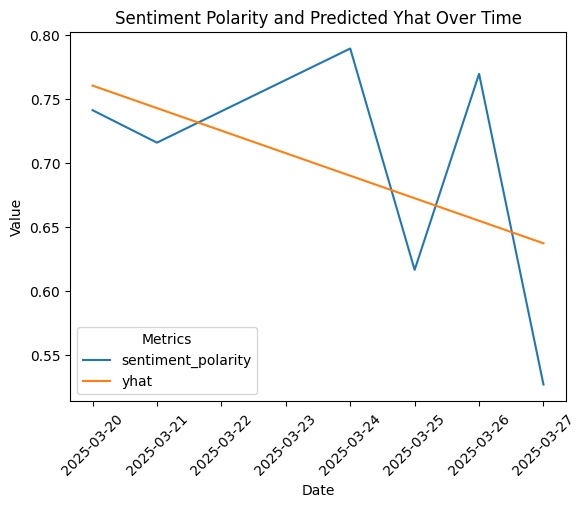

The RMSE is: 0.08108478523741687


In [13]:
from datetime import timedelta

# We'll make a psuedo train-test split 

cutoff_date = datetime(month=3, day=20, year=2025)

train = articles1[articles1['date'] < cutoff_date]
test = articles1[articles1['date'] >= cutoff_date]

sentiment_df = test[['date','sentiment_polarity']].rename(mapper = {"date" : "ds", "sentiment_polarity" : "y"}, axis = 1)

m = Prophet()
m.fit(sentiment_df)

# # For on the data future use-case
# future = m.make_future_dataframe(periods=5)
# future.tail()

# Since we're testing with current data: 
future = pd.DataFrame({"ds" : [cutoff_date + timedelta(days= i) for i in range(0,8)]})
future.head()

forecast = m.predict(future)
display(forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])
display(test)

sentiment_regressor = forecast['yhat']

from sklearn.metrics import mean_squared_error

# Join the tables together
merged = pd.merge(test, forecast[['ds','yhat']], how='inner', left_on='date', right_on='ds').drop(columns=['ds'])

# Reshape the DataFrame to a long format for easy plotting with seaborn
plot_data = merged.melt(id_vars=['date'], value_vars=['sentiment_polarity', 'yhat'], 
                        var_name='Metric', value_name='Value')

# Plot using seaborn
sns.lineplot(
    data=plot_data,
    x="date",
    y="Value",
    hue="Metric"  # Different colors for 'sentiment_polarity' and 'yhat'
)

# Optional: Add labels and a title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Sentiment Polarity and Predicted Yhat Over Time")
plt.legend(title="Metrics")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

rmse = np.sqrt(mean_squared_error(merged['yhat'], merged['sentiment_polarity']))
print(f"The RMSE is: {rmse}")

12:04:30 - cmdstanpy - INFO - Chain [1] start processing
12:04:30 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2025-03-20,1.091677,1.090686,1.092654
1,2025-03-21,1.086253,1.085274,1.087156
2,2025-03-22,1.086001,1.085090,1.086942
3,2025-03-23,1.085749,1.084736,1.086750
4,2025-03-24,1.085497,1.084531,1.086396
5,2025-03-25,1.082483,1.081610,1.083421
6,2025-03-26,1.081774,1.080946,1.082756
7,2025-03-27,1.081066,1.080102,1.082011


,date,sentiment_polarity,High,Low
112,2025-03-20,0.741522,1.091751,1.081830
113,2025-03-21,0.716170,1.086130,1.080567
114,2025-03-24,0.789688,1.085694,1.079075
115,2025-03-25,0.616771,1.083072,1.077865
116,2025-03-26,0.769901,1.080229,1.076878
117,2025-03-27,0.527181,1.081876,1.074206


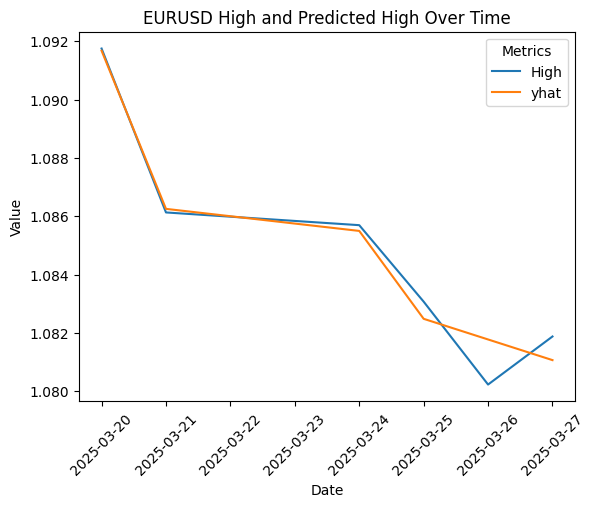

The RMSE is: 0.0007585468330507072


In [14]:
from datetime import timedelta

# We'll make a psuedo train-test split 

target = 'High' # Set this as function input

cutoff_date = datetime(month=3, day=20, year=2025)

train = articles1[articles1['date'] < cutoff_date]
test = articles1[articles1['date'] >= cutoff_date]

sentiment_df = test[['date','High']].rename(mapper = {"date" : "ds", target : "y"}, axis = 1)

m = Prophet()
m.fit(sentiment_df)

# # For on the data future use-case
# future = m.make_future_dataframe(periods=5)
# future.tail()

# Since we're testing with current data: 
future = pd.DataFrame({"ds" : [cutoff_date + timedelta(days= i) for i in range(0,8)]})
future.head()

forecast = m.predict(future)
display(forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])
display(test)

from sklearn.metrics import mean_squared_error

# Join the tables together
merged = pd.merge(test, forecast[['ds','yhat']], how='inner', left_on='date', right_on='ds').drop(columns=['ds'])

# Reshape the DataFrame to a long format for easy plotting with seaborn
plot_data = merged.melt(id_vars=['date'], value_vars=[target, 'yhat'], 
                        var_name='Metric', value_name='Value')

# Plot using seaborn
sns.lineplot(
    data=plot_data,
    x="date",
    y="Value",
    hue="Metric"  # Different colors for 'sentiment_polarity' and 'yhat'
)

# Optional: Add labels and a title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("EURUSD High and Predicted High Over Time")
plt.legend(title="Metrics")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

rmse = np.sqrt(mean_squared_error(merged['yhat'], merged[target]))
print(f"The RMSE is: {rmse}")

With `sentiment_polarity` as an additional regressor

12:04:36 - cmdstanpy - INFO - Chain [1] start processing
12:04:37 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,sentiment_polarity
0,2025-03-20,1.091534,1.091534,1.091534,-0.000762
1,2025-03-21,1.085826,1.085826,1.085826,-0.000563
2,2025-03-22,1.086158,1.086158,1.086158,-0.000363
3,2025-03-23,1.086490,1.086490,1.086490,-0.000163
4,2025-03-24,1.086822,1.086822,1.086822,0.000036
5,2025-03-25,1.082438,1.082438,1.082438,0.000236
6,2025-03-26,1.081532,1.081532,1.081532,0.000436
7,2025-03-27,1.080626,1.080626,1.080626,0.000635


,date,sentiment_polarity,High,Low
112,2025-03-20,0.741522,1.091751,1.081830
113,2025-03-21,0.716170,1.086130,1.080567
114,2025-03-24,0.789688,1.085694,1.079075
115,2025-03-25,0.616771,1.083072,1.077865
116,2025-03-26,0.769901,1.080229,1.076878
117,2025-03-27,0.527181,1.081876,1.074206


,date,sentiment_polarity,High,Low,yhat
0,2025-03-20,0.741522,1.091751,1.081830,1.091534
1,2025-03-21,0.716170,1.086130,1.080567,1.085826
2,2025-03-24,0.789688,1.085694,1.079075,1.086822
3,2025-03-25,0.616771,1.083072,1.077865,1.082438
4,2025-03-26,0.769901,1.080229,1.076878,1.081532
5,2025-03-27,0.527181,1.081876,1.074206,1.080626


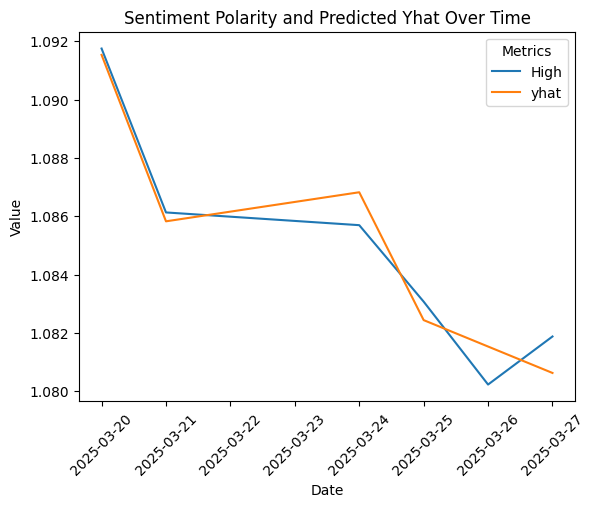

The RMSE is: 0.0009198968356999293


In [15]:
from datetime import timedelta

# We'll make a psuedo train-test split 

target = 'High' # Set this as function input

cutoff_date = datetime(month=3, day=20, year=2025)

train = articles1[articles1['date'] < cutoff_date]
test = articles1[articles1['date'] >= cutoff_date]

sentiment_df = test[['date','High','sentiment_polarity']].rename(mapper = {"date" : "ds", target : "y"}, axis = 1)

m = Prophet()
m.add_regressor('sentiment_polarity')
m.fit(sentiment_df)

# # For on the data future use-case
# future = m.make_future_dataframe(periods=5)
# future.tail()

# Since we're testing with current data: 
future = pd.DataFrame({"ds" : [cutoff_date + timedelta(days= i) for i in range(0,8)], "sentiment_polarity" : sentiment_regressor})

forecast = m.predict(future)
display(forecast[['ds','yhat', 'yhat_lower', 'yhat_upper', 'sentiment_polarity']])
display(test)

from sklearn.metrics import mean_squared_error

# Join the tables together
merged = pd.merge(test, forecast[['ds','yhat']], how='inner', left_on='date', right_on='ds').drop(columns=['ds'])
display(merged)

# Reshape the DataFrame to a long format for easy plotting with seaborn
plot_data = merged.melt(id_vars=['date'], value_vars=[target, 'yhat'], 
                        var_name='Metric', value_name='Value')

# Plot using seaborn
sns.lineplot(
    data=plot_data,
    x="date",
    y="Value",
    hue="Metric"  # Different colors for 'sentiment_polarity' and 'yhat'
)

# Optional: Add labels and a title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Sentiment Polarity and Predicted Yhat Over Time")
plt.legend(title="Metrics")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

rmse = np.sqrt(mean_squared_error(merged['yhat'], merged[target]))
print(f"The RMSE is: {rmse}")

The model works better WITHOUT news sentiment lmao

Testing to adopt as app

In [25]:
import pandas as pd
from prophet import Prophet
from datetime import datetime, timedelta
from prophet.plot import plot_plotly, plot_components_plotly
from pathlib import Path
import plotly.graph_objects as go

# --- Helper: Determines the predictions of the data --- 
def record_predictions(current_pred):
    file_path = f"data/prediction_data/{ticker}_predictions_data"
    logging_file = Path(file_path)

    if logging_file.is_file():
        print(f"Record of predictions for {ticker} was found!")
        past_pred = pd.read_parquet(file_path)
    else:
        print(f"No record of predictions for {ticker} was found... initializing file data to be written!")
        past_pred = pd.DataFrame(columns=['date', 'high_pred', 'low_pred', 'sent_pred'])

    # If there are rows with duplicate `date` (lets say we're getting new current data and the model is refit for the day)
    filtered_past_pred = past_pred[~past_pred['date'].isin(current_pred['date'])]
    to_write = pd.concat([current_pred, filtered_past_pred])
    
    to_write.to_parquet(f"../data/prediction_data/{ticker}_predictions_data")
    return

def generate_sentiment_predictions(data):
    # Get the sentiment data
    sentiment_df = data[['date','sentiment_polarity']].rename(mapper = {"date" : "ds", "sentiment_polarity" : "y"}, axis = 1)

    # Init and train a model to it
    m_sent = Prophet() # m_sent = model sentiment
    m_sent.fit(sentiment_df)

    # Predict for the next 7 days
    f_sent = pd.DataFrame({"ds" : [datetime.now().date() + timedelta(days= i) for i in range(0,8)]}) # f_sent = future sentiment
    f_sent.head()

    fc_sent = m_sent.predict(f_sent)

    return fc_sent[['ds','yhat']]

# --- Generates Prophet Model to predict ticker values with Sentiment ---
def prophet_with_sentiment(data, target, sent_regr):

    ticker_df = data[['date', target,'sentiment_polarity']].rename(mapper = {"date" : "ds", target : "y"}, axis = 1)

    m_ticker = Prophet()
    m_ticker.add_regressor('sentiment_polarity')
    m_ticker.fit(ticker_df)

    # Predict for the next 7 days! 
    future = pd.DataFrame({"ds" : [datetime.now() + timedelta(days= i) for i in range(0,8)], "sentiment_polarity" : sent_regr['yhat']})

    forecast = m_ticker.predict(future)

    return forecast[['ds','yhat']]


# --- Function to consolidate high and low data --- 

def generate_predictions(ticker):
    data = pd.read_parquet(f"../data/modelling_dataset/{ticker}_modelling_dataset")

    sent_regr = generate_sentiment_predictions(data)

    high_df = prophet_with_sentiment(data, "High", sent_regr).rename(mapper = {"ds" : "date", "yhat" : "high_pred"}, axis = 1)
    low_df = prophet_with_sentiment(data, "Low", sent_regr).rename(mapper = {"ds" : "date", "yhat" : "low_pred"}, axis = 1)
    
    # Theres an error in that the slight delay in seconds execution in predicting High and Low data will cause an issue, fix that:
    sent_regr = sent_regr.rename(mapper = {"ds" : "date", "yhat" : "sent_pred"}, axis = 1)
    sent_regr['date'] = sent_regr['date'].dt.date
    high_df['date'] = high_df['date'].dt.date
    low_df['date'] = low_df['date'].dt.date

    predicts_merged = pd.merge(high_df, low_df, on='date')
    predicts_merged = pd.merge(predicts_merged, sent_regr, on='date')
    print("DEBUG: see data merged!")
    print(predicts_merged.info())

    record_predictions(predicts_merged)

    display(predicts_merged)

    return predicts_merged

# --- Charting Function --- 
def chart_est_value(df, ticker):
    # Create the plot
    fig = go.Figure()

    # Add high_pred line
    fig.add_trace(go.Scatter(
        x=df['date'],
        y=df['high_pred'],
        mode='lines',
        name='High Prediction',
        line=dict(color='blue')
    ))

    # Add low_pred line
    fig.add_trace(go.Scatter(
        x=df['date'],
        y=df['low_pred'],
        mode='lines',
        name='Low Prediction',
        line=dict(color='red')
    ))

    # Add filled area between high_pred and low_pred
    fig.add_trace(go.Scatter(
        x=pd.concat([df['date'], df['date'][::-1]]),
        y=pd.concat([df['high_pred'], df['low_pred'][::-1]]),
        fill='toself',
        fillcolor='rgba(0, 100, 80, 0.2)',  # Semi-transparent fill
        line=dict(color='rgba(255,255,255,0)'),  # No visible line
        hoverinfo='skip',
        showlegend=False
    ))

    # Update layout
    fig.update_layout(
        title=f"{ticker} Daily High and Low Predictions",
        xaxis_title="Date",
        yaxis_title=f"{ticker} Exchange Rate",
        legend_title="Legend",
        template="plotly_white"
    )

    # Return the plot 
    return fig

def chart_est_sent(df, ticker):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df['date'],
        y=df['sent_pred'],
        mode='lines',
        name='High Prediction',
        line=dict(color='#AB63FA')
    ))

    # Update layout
    fig.update_layout(
        title=f"{ticker} Daily News Sentiment Prediction from FXStreet.com",
        xaxis_title="Date",
        yaxis_title=f"{ticker} Sentiment Polarity",
        legend_title="Legend",
        template="plotly_white"
    )

    fig.show()

# --- RUNNING THE PROGRAM --- 

# Create a ticker for all currency pairs
EURUSD = "EURUSD=X" # EUR/USD
USDJPY = "JPY=X"
GBPUSD = "GBPUSD=X"

for ticker in [EURUSD, USDJPY, GBPUSD]:
    predicts = generate_predictions(ticker)
    # Streamlit 
    # chart_est_value(predicts, ticker)
    # chart_est_sent(predicts, ticker)
# --- Create a function that will record the error --- 

13:09:26 - cmdstanpy - INFO - Chain [1] start processing
13:09:27 - cmdstanpy - INFO - Chain [1] done processing
13:09:27 - cmdstanpy - INFO - Chain [1] start processing
13:09:27 - cmdstanpy - INFO - Chain [1] done processing
13:09:27 - cmdstanpy - INFO - Chain [1] start processing
13:09:27 - cmdstanpy - INFO - Chain [1] done processing


DEBUG: see data merged!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       8 non-null      object 
 1   high_pred  8 non-null      float64
 2   low_pred   8 non-null      float64
 3   sent_pred  8 non-null      float64
dtypes: float64(3), object(1)
memory usage: 388.0+ bytes
None
No record of predictions for EURUSD=X was found... initializing file data to be written!


C:\Users\sumag\AppData\Local\Temp\ipykernel_21436\2296453140.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  to_write = pd.concat([current_pred, filtered_past_pred])


,date,high_pred,low_pred,sent_pred
0,2025-03-31,1.103664,1.096633,0.713107
1,2025-04-01,1.103588,1.096189,0.716010
2,2025-04-02,1.106927,1.098935,0.721380
3,2025-04-03,1.104580,1.097965,0.679631
4,2025-04-04,1.109334,1.100847,0.699221
5,2025-04-05,1.105071,1.097730,0.779188
6,2025-04-06,1.109775,1.103246,0.903682
7,2025-04-07,1.112754,1.105625,0.714620


13:09:27 - cmdstanpy - INFO - Chain [1] start processing
13:09:27 - cmdstanpy - INFO - Chain [1] done processing
13:09:28 - cmdstanpy - INFO - Chain [1] start processing
13:09:28 - cmdstanpy - INFO - Chain [1] done processing
13:09:28 - cmdstanpy - INFO - Chain [1] start processing
13:09:28 - cmdstanpy - INFO - Chain [1] done processing


DEBUG: see data merged!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       8 non-null      object 
 1   high_pred  8 non-null      float64
 2   low_pred   8 non-null      float64
 3   sent_pred  8 non-null      float64
dtypes: float64(3), object(1)
memory usage: 388.0+ bytes
None
No record of predictions for JPY=X was found... initializing file data to be written!


C:\Users\sumag\AppData\Local\Temp\ipykernel_21436\2296453140.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  to_write = pd.concat([current_pred, filtered_past_pred])


,date,high_pred,low_pred,sent_pred
0,2025-03-31,148.925258,148.045755,0.749676
1,2025-04-01,149.164249,148.039132,0.745047
2,2025-04-02,149.263497,148.137145,0.755915
3,2025-04-03,149.036959,147.986708,0.727231
4,2025-04-04,148.884556,147.912640,0.719964
5,2025-04-05,148.672330,148.218265,0.731300
6,2025-04-06,148.739764,147.789115,0.731101
7,2025-04-07,148.577821,147.742284,0.748281


13:09:28 - cmdstanpy - INFO - Chain [1] start processing
13:09:28 - cmdstanpy - INFO - Chain [1] done processing
13:09:28 - cmdstanpy - INFO - Chain [1] start processing
13:09:28 - cmdstanpy - INFO - Chain [1] done processing
13:09:29 - cmdstanpy - INFO - Chain [1] start processing
13:09:29 - cmdstanpy - INFO - Chain [1] done processing


DEBUG: see data merged!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       8 non-null      object 
 1   high_pred  8 non-null      float64
 2   low_pred   8 non-null      float64
 3   sent_pred  8 non-null      float64
dtypes: float64(3), object(1)
memory usage: 388.0+ bytes
None
No record of predictions for GBPUSD=X was found... initializing file data to be written!


C:\Users\sumag\AppData\Local\Temp\ipykernel_21436\2296453140.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  to_write = pd.concat([current_pred, filtered_past_pred])


,date,high_pred,low_pred,sent_pred
0,2025-03-31,1.312426,1.306134,0.653141
1,2025-04-01,1.313564,1.307382,0.630855
2,2025-04-02,1.315702,1.307389,0.672858
3,2025-04-03,1.314912,1.308194,0.589851
4,2025-04-04,1.312825,1.306556,0.648967
5,2025-04-05,1.309329,1.302519,0.640112
6,2025-04-06,1.316209,1.309501,0.640077
7,2025-04-07,1.320841,1.314589,0.652897


In [27]:
import pandas as pd

data = pd.read_parquet(f"../data/prediction_data/EURUSD=X_predictions_data")
data

,date,high_pred,low_pred,sent_pred
0,2025-03-31,1.103664,1.096633,0.713107
1,2025-04-01,1.103588,1.096189,0.716010
2,2025-04-02,1.106927,1.098935,0.721380
3,2025-04-03,1.104580,1.097965,0.679631
4,2025-04-04,1.109334,1.100847,0.699221
5,2025-04-05,1.105071,1.097730,0.779188
6,2025-04-06,1.109775,1.103246,0.903682
7,2025-04-07,1.112754,1.105625,0.714620


In [32]:
agg_data = pd.read_parquet("..\data\modelling_dataset\EURUSD=X_modelling_dataset")
agg_data

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\sumag\AppData\Local\Temp\ipykernel_21436\1648062179.py:1: SyntaxWarning: invalid escape sequence '\d'
  agg_data = pd.read_parquet("..\data\modelling_dataset\EURUSD=X_modelling_dataset")


,date,sentiment_polarity,High,Low
0,2024-10-09,0.775951,1.098056,1.094068
1,2024-10-10,0.681009,1.095446,1.091405
2,2024-10-11,0.514638,1.095422,1.092741
3,2024-10-14,0.693515,1.093972,1.090572
4,2024-10-15,0.746610,1.091822,1.088578
...,...,...,...,...
114,2025-03-24,0.789688,1.085694,1.079075
115,2025-03-25,0.616771,1.083072,1.077865
116,2025-03-26,0.769901,1.080229,1.076878
117,2025-03-27,0.527181,1.081876,1.074206


In [31]:
data.join(agg_data, on='date', how='left', lsuffix='', rsuffix='_other')

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\sumag\AppData\Local\Temp\ipykernel_21436\1468576025.py:1: SyntaxWarning: invalid escape sequence '\d'
  agg_data = pd.read_parquet("..\data\modelling_dataset\EURUSD=X_modelling_dataset")


,date,high_pred,low_pred,sent_pred,date_other,sentiment_polarity,High,Low
0,2025-03-31,1.103664,1.096633,0.713107,NaN,NaN,NaN,NaN
1,2025-04-01,1.103588,1.096189,0.716010,NaN,NaN,NaN,NaN
2,2025-04-02,1.106927,1.098935,0.721380,NaN,NaN,NaN,NaN
3,2025-04-03,1.104580,1.097965,0.679631,NaN,NaN,NaN,NaN
4,2025-04-04,1.109334,1.100847,0.699221,NaN,NaN,NaN,NaN
5,2025-04-05,1.105071,1.097730,0.779188,NaN,NaN,NaN,NaN
6,2025-04-06,1.109775,1.103246,0.903682,NaN,NaN,NaN,NaN
7,2025-04-07,1.112754,1.105625,0.714620,NaN,NaN,NaN,NaN


In [34]:
pd.read_parquet("..\data\error_data\EURUSD=X_error_data")

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\sumag\AppData\Local\Temp\ipykernel_21436\1241439885.py:1: SyntaxWarning: invalid escape sequence '\d'
  pd.read_parquet("..\data\error_data\EURUSD=X_error_data")


,date,high_pred,low_pred,sent_pred,high_real,low_real
0,2025-03-31,1.103634,1.096637,0.713107,1.085069,1.078749


We are following this tutorial: https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

To implement AutoRegression in our application

### Lagged Plots and Autocorrelation Plots

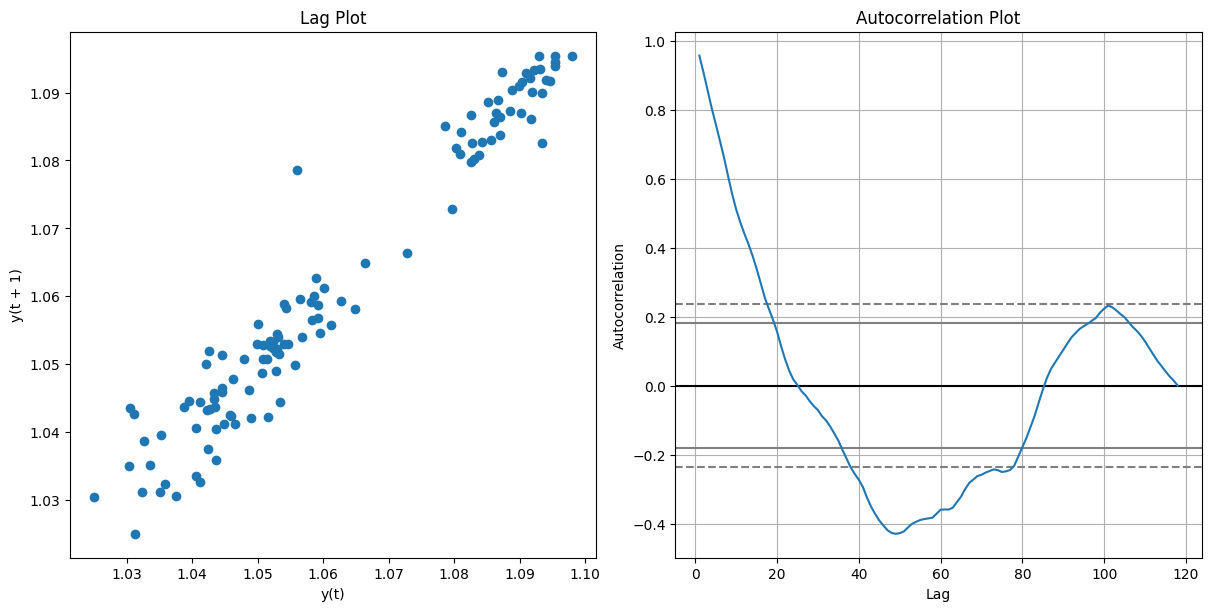

Coefficients: [0.03546008 0.96648491]
Test RMSE: 0.01727897148809157


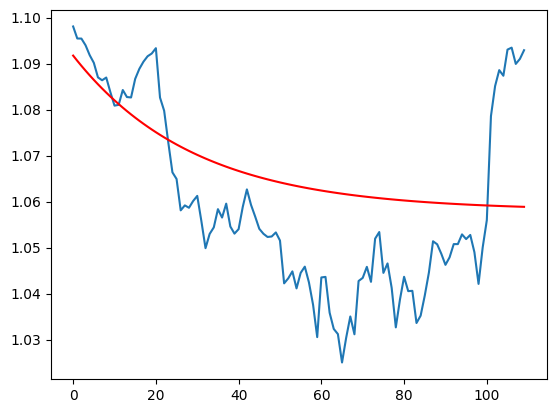

In [ ]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# Create subplots
fig, (left, right) = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6), layout="constrained"
)

series = articles1['High']

# Plot lag plot on the left axis
plt.sca(left)
lag_plot(series)
left.set_title("Lag Plot")  # Optional: Add a title to the left subplot

# Plot autocorrelation on the right axis
plt.sca(right)
pd.plotting.autocorrelation_plot(series, ax=right)
right.set_title("Autocorrelation Plot")  # Optional: Add a title to the right subplot

# Show the figure
plt.show()


""" Modelling """

# split into train and test sets, testing model on the past 7 days! 

values = pd.DataFrame(articles1['High'].values)
dataframe = pd.concat([values.shift(1), values], axis = 1)
dataframe.columns = ['t-1', 't+1']

X = dataframe.values
train, test = X[:len(X)-7], X[len(X)-7:]  # Use the first part for training, last 7 for testing

train, test = X[1:len(X)-7], X[1:len(X)-7]
X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

train = train[:, 0]  # Take only the first column as the endogenous variable (target)
test = test[:, 0]    # Same for the test dataset

# Train AutoRegression Model
model = AutoReg(train, lags=1)
model_fit = model.fit()
print(f'Coefficients: {model_fit.params}')

# Make Predictions
predictions = model_fit.predict(start = len(train), 
                                end=len(train) + len(test) - 1, 
                                dynamic = False)

# for i in range(len(predictions)):
#     print("-----------------------------------------------------")
#     print(f"predicted = {predictions[i]} \nexpected = {test[i]}")

rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse}')

# Plot the results 
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

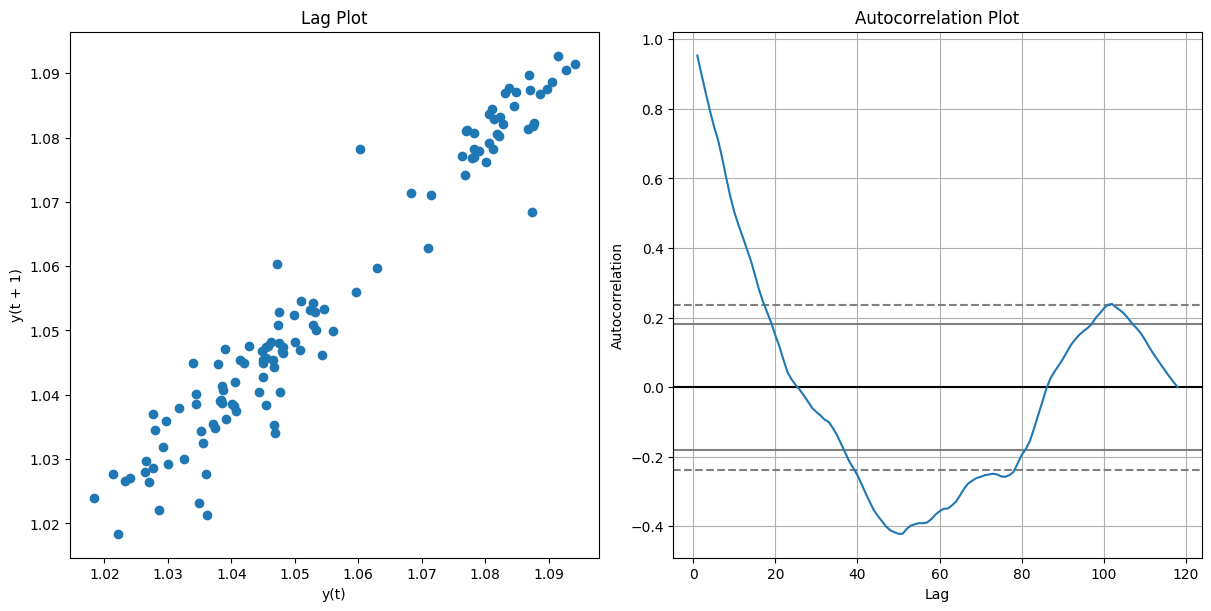

Coefficients: [0.04075206 0.96121431]
Test RMSE: 0.01685169340361358


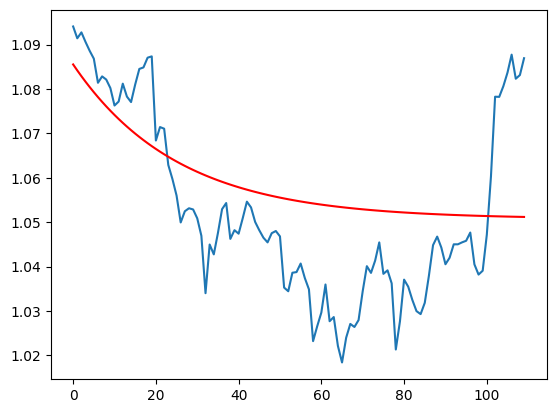

In [73]:
# Create subplots
fig, (left, right) = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6), layout="constrained"
)

series = articles1['Low']

# Plot lag plot on the left axis
plt.sca(left)
lag_plot(series)
left.set_title("Lag Plot")  # Optional: Add a title to the left subplot

# Plot autocorrelation on the right axis
plt.sca(right)
pd.plotting.autocorrelation_plot(series, ax=right)
right.set_title("Autocorrelation Plot")  # Optional: Add a title to the right subplot

# Show the figure
plt.show()

""" Modelling """

# split into train and test sets, testing model on the past 7 days! 

values = pd.DataFrame(articles1['Low'].values)
dataframe = pd.concat([values.shift(1), values], axis = 1)
dataframe.columns = ['t-1', 't+1']

X = dataframe.values
train, test = X[:len(X)-7], X[len(X)-7:]  # Use the first part for training, last 7 for testing

train, test = X[1:len(X)-7], X[1:len(X)-7]
X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

train = train[:, 0]  # Take only the first column as the endogenous variable (target)
test = test[:, 0]    # Same for the test dataset

# Train AutoRegression Model
model = AutoReg(train, lags=1)
model_fit = model.fit()
print(f'Coefficients: {model_fit.params}')

# Make Predictions
predictions = model_fit.predict(start = len(train), 
                                end=len(train) + len(test) - 1, 
                                dynamic = False)

# for i in range(len(predictions)):
#     print("-----------------------------------------------------")
#     print(f"predicted = {predictions[i]} \nexpected = {test[i]}")

rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse}')

# Plot the results 
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

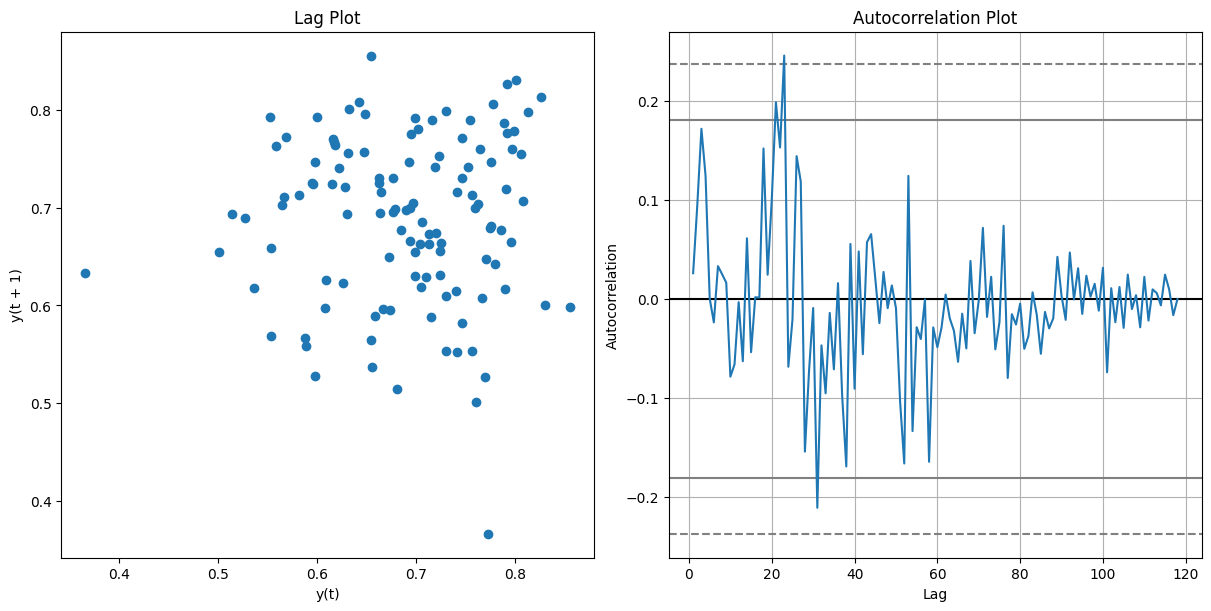

Coefficients: [ 0.23674235 -0.00202916  0.12728753  0.29303025  0.04209684 -0.0528974
 -0.11396701  0.13386151 -0.05732426 -0.03074099 -0.06018861 -0.03676116
  0.10667649 -0.05491748  0.04464499 -0.08061837 -0.09687683 -0.00999378
  0.1215288  -0.0668809   0.15124643  0.14202763  0.21754505  0.16280569
 -0.26394636 -0.26043049  0.04034191  0.26727194]
-----------------------------------------------------
predicted = 0.8290298650735737 
expected = 0.7759506702423096
-----------------------------------------------------
predicted = 0.6966712445571369 
expected = 0.6810092926025391
-----------------------------------------------------
predicted = 0.6248733243350633 
expected = 0.5146377682685852
-----------------------------------------------------
predicted = 0.7467165962501744 
expected = 0.6935147047042847
-----------------------------------------------------
predicted = 0.6842292679424368 
expected = 0.7466097474098206
-----------------------------------------------------
predicted =

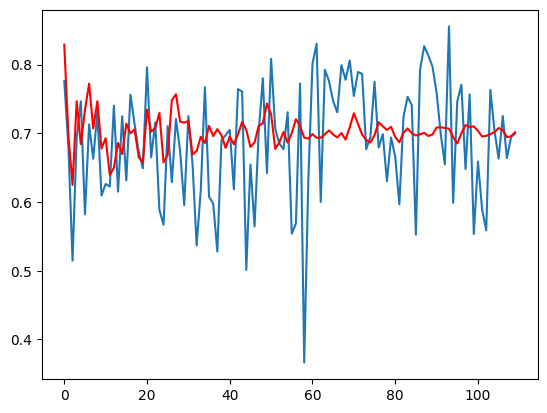

In [71]:
# Create subplots
fig, (left, right) = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6), layout="constrained"
)

series = articles1['sentiment_polarity']

# Plot lag plot on the left axis
plt.sca(left)
lag_plot(series)
left.set_title("Lag Plot")  # Optional: Add a title to the left subplot

# Plot autocorrelation on the right axis
plt.sca(right)
pd.plotting.autocorrelation_plot(series, ax=right)
right.set_title("Autocorrelation Plot")  # Optional: Add a title to the right subplot

# Show the figure
plt.show()

""" Modelling """

values = pd.DataFrame(articles1['sentiment_polarity'].values)
dataframe = pd.concat([values.shift(1), values], axis = 1)
dataframe.columns = ['t-1', 't+1']

# split into train and test sets, testing model on the past 7 days! 
X = dataframe.values
train, test = X[:len(X)-7], X[len(X)-7:]  # Use the first part for training, last 7 for testing

train, test = X[1:len(X)-7], X[1:len(X)-7]
X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

train = train[:, 0]  # Take only the first column as the endogenous variable (target)
test = test[:, 0]    # Same for the test dataset

# Train AutoRegression Model
model = AutoReg(train, lags=27)
model_fit = model.fit()
print(f'Coefficients: {model_fit.params}')

# Make Predictions
predictions = model_fit.predict(start = len(train), 
                                end=len(train) + len(test) - 1, 
                                dynamic = False)

for i in range(len(predictions)):
    print("-----------------------------------------------------")
    print(f"predicted = {predictions[i]} \nexpected = {test[i]}")

rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse}')

# Plot the results 
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

After modelling; we need to save our model to be used by our front-end to give our users the forecasts they need!

### Conducting Pearson Correlation Coefficients 

Ticker values, Aggregated by Day 

In [37]:
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis = 1)
dataframe.columns = ['t-1','t+1']
result = dataframe.corr()
print(f"The Pearson correlation coefficient for daily Forex value is: \n{result}")

The Pearson correlation coefficient for daily Forex value is: 
          t-1       t+1
t-1  1.000000  0.996379
t+1  0.996379  1.000000


Sentiment Analysis, Aggregated by Day

In [51]:
# display(series1)
values1 = pd.DataFrame(series1.values)
# display(values1)
dataframe1 = pd.concat([values1.shift(1), values1], axis = 1)
# display(dataframe1)
dataframe1.columns = ['t-1','t+1']
result1 = dataframe1.corr()
print(result1)

          t-1       t+1
t-1  1.000000  0.148592
t+1  0.148592  1.000000


Very weak correlation of sentiment analysis between sentiment polarity forecasting. This might be because let's say we're working with JPY=X (USD/JPY); it indicates the number of JPY to purchase 1 USD. 

So in relation; if we find an article talks positively about JPY, it should be a positive sentiment. And vice versa. 

If we find an article that tlks negatively about USD, it should be a positive sentiment. And vice versa.

# Modelling Using SARIMAX

In [1]:
from pmdarima import auto_arima

# References: 

1. https://facebook.github.io/prophet/docs/quick_start.html#python-api (2025-03-22)
2. https://www.youtube.com/watch?v=ySiKZwoTX54 (2025-04-05)

Experiment